# Loading libraries

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from kalman import Kalman_Filter
from AR1 import particle_filter, generator_ar_1, initial_particle, likelihood_function, transition_sample

# Generate Samples

In [73]:
def generator_ar(sigma_epsilon_square=2, sigma_eta_square=0.02, phi=0.975, mu=0.5, T=5000, seed=2345):
    np.random.seed(seed=seed)
    x = 0
    #x = mu + np.random.randn(1) * np.sqrt(sigma_eta_square)
    ys = np.zeros(T)
    for i in range(T):
        ys[i] = x + np.random.randn(1) * np.sqrt(sigma_epsilon_square)
        x = (x - mu) * phi + mu + np.random.randn(1) * \
            np.sqrt(sigma_eta_square)
    print('sample generated with success !')
    return ys

In [74]:
# parameters
sigma_epsilon_square_0 = 2
sigma_eta_square_0 = 0.02
phi_0 = 0.975
mu_0 = 0.5

# T = 5000
# N = 3500
T = 5000
observations_5000 = generator_ar(sigma_epsilon_square=sigma_epsilon_square_0,
                              sigma_eta_square=sigma_eta_square_0, phi=phi_0, mu=mu_0, T=T)

sample generated with success !


# Log-Error: kalman vs particle

In [83]:
A, b = phi_0, (1-phi_0)*mu_0
print('Begin kalman filter: ')
_, ct = Kalman_Filter.compute_log_likelihood(Y=observations_5000[1:], 
                                             mu0=(1-phi_0)*mu_0, 
                                             V0=sigma_eta_square_0, 
                                             A=A, 
                                             b=b, 
                                             V=sigma_eta_square_0, 
                                             V_epi=sigma_epsilon_square_0)
p0 = [norm.pdf(observations_5000[0], loc=0, scale=np.sqrt(sigma_epsilon_square_0))]
log_lkh_kalman = np.concatenate([p0, np.log(ct)])
print('End kalman filter!')

Begin kalman filter: 
Begin compute likelihoods by kalman_filter
End kalman filter!


In [84]:
N = 300

print('Begin Particle Filter:')
initial_particles = initial_particle(N=N)
likelihoods_particle = particle_filter(observations=observations_5000, 
                              initial_particles=initial_particles,
                              likelihood_func=likelihood_function, 
                              transition=transition_sample, 
                              mu=mu_0,
                              phi=phi_0,
                              sigma_eta_square=sigma_eta_square_0,
                              sigma_epsilon_square=sigma_epsilon_square_0,
                              N=N,seed=1234)
log_lkh_particle = np.log(likelihoods_particle)
print('End Particle Filter!')

Begin Particle Filter:
End Particle Filter!


In [87]:
sum(log_lkh_kalman)

-9027.657378568123

In [88]:
sum(log_lkh_particle)

-9029.6941026660552

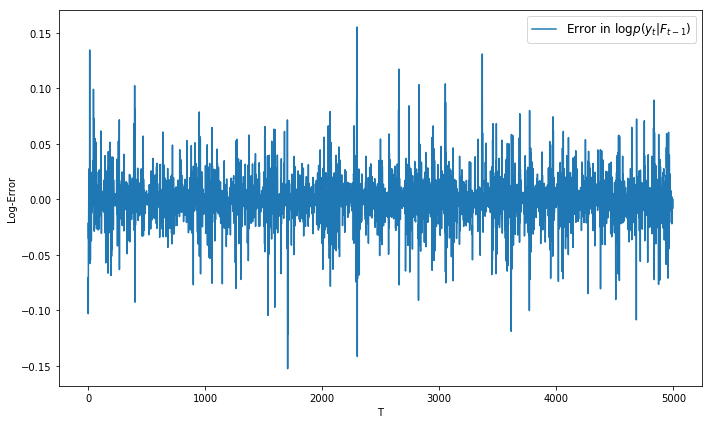

In [158]:
plt.figure(figsize=(10, 6))
plt.plot(log_lkh_particle[3:] - log_lkh_kalman[3:], label='Error in '+r'$\log p(y_{t}|F_{t-1})$')
#plt.plot(log_lkh_kalman, label='kalman')
#plt.plot(log_lkh_particle, label='particle')
plt.xlabel('T')
plt.ylabel('Log-Error')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/ar_logerror_300_5000.png')
plt.show()

In [107]:
mus = [i*0.03 for i in range(10,22)]

In [98]:
# From guo's comptuer
mus = [i*0.03 for i in range(10,22)]
#mus = [i*0.03 for i in range(18,22)]
log_likelihoods_mu = [[], []]
for mu in mus:
    A = phi_0
    b = (1 - phi_0) * mu
    log_lkh_1, _ = Kalman_Filter.compute_log_likelihood(Y=observations_5000[1:],
                                    mu0=b, 
                                    V0=sigma_eta_square_0, 
                                    A=A, 
                                    b=b, 
                                    V=sigma_eta_square_0,
                                    V_epi=sigma_epsilon_square_0)
    p0 = norm.pdf(observations_5000[0], loc=0, scale=np.sqrt(sigma_epsilon_square_0))
    log_lkh_1 += np.log(p0)
    print("kalman: mu= %0.2f" % mu, " log-lokelihood= %0.3f" % log_lkh_1)
    log_likelihoods_mu[0].append(log_lkh_1)
    
    initial_particles = initial_particle(N=N)
    likelihoods_particle = particle_filter(observations=observations_5000, 
                                  initial_particles=initial_particles,
                                  likelihood_func=likelihood_function, 
                                  transition=transition_sample, 
                                  mu=mu,
                                  phi=phi_0,
                                  sigma_eta_square=sigma_eta_square_0,
                                  sigma_epsilon_square=sigma_epsilon_square_0,
                                  N=N,seed=1234)
    log_lkh_2 = np.sum(np.log(likelihoods_particle))
    print("particle: mu= %0.2f" % mu, " log-lokelihood= %0.3f" % log_lkh_2)
    log_likelihoods_mu[1].append(log_lkh_2)

Begin compute likelihoods by kalman_filter
kalman: mu= 0.54  log-lokelihood= -9029.590
particle: mu= 0.54  log-lokelihood= -9029.639
Begin compute likelihoods by kalman_filter
kalman: mu= 0.57  log-lokelihood= -9029.770
particle: mu= 0.57  log-lokelihood= -9029.758
Begin compute likelihoods by kalman_filter
kalman: mu= 0.60  log-lokelihood= -9030.083
particle: mu= 0.60  log-lokelihood= -9030.014
Begin compute likelihoods by kalman_filter
kalman: mu= 0.63  log-lokelihood= -9030.528
particle: mu= 0.63  log-lokelihood= -9030.405


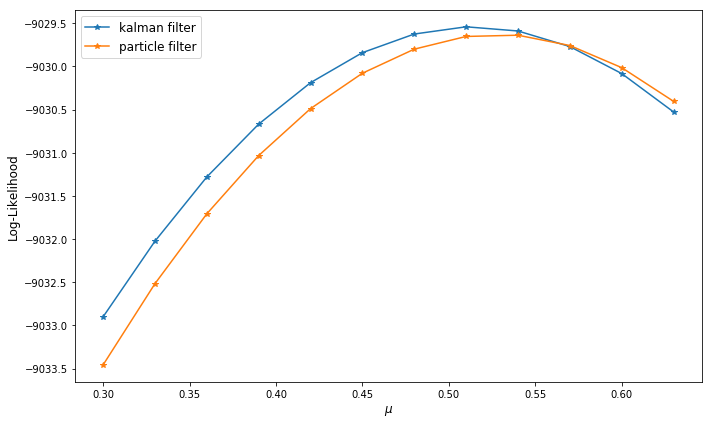

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(mus, log_likelihoods_mu[0], '-*',label='kalman filter')
plt.plot(mus, log_likelihoods_mu[1], '*-',label='particle filter')
plt.xlabel(r'$\mu$', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/mu_log_likelihood_300_5000.png')
plt.show()

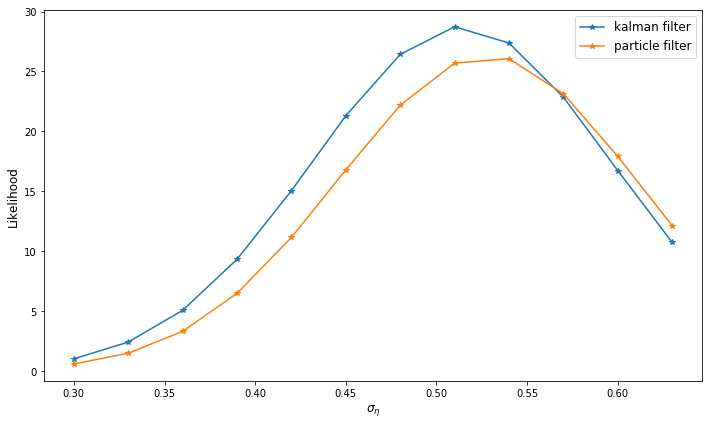

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(mus, np.exp(log_likelihoods_mu[0]-log_likelihoods_mu[0][0]), '-*',label='kalman filter')
plt.plot(mus, np.exp(log_likelihoods_mu[1]-log_likelihoods_mu[0][0]), '*-',label='particle filter')
plt.xlabel(r'$\sigma_{\eta}$', fontsize=12)
plt.ylabel('Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/mu_likelihood_300_5000.png')
plt.show()

In [134]:
etas = [i*0.01 for i in range(11,17)]
#etas = [i*0.01 for i in range(11,12)]
log_likelihoods_eta = [[], []]
for eta in etas:
    A = phi_0
    b = (1 - phi_0) * mu_0
    log_lkh_1, _ = Kalman_Filter.compute_log_likelihood(Y=observations_5000[1:],
                                    mu0=b, 
                                    V0=eta**2, 
                                    A=A, 
                                    b=b, 
                                    V=eta**2,
                                    V_epi=sigma_epsilon_square_0)
    p0 = norm.pdf(observations_5000[0], loc=0, scale=np.sqrt(sigma_epsilon_square_0))
    log_lkh_1 += np.log(p0)
    print("kalman: sigma_eta= %0.2f" % eta, " log-lokelihood= %0.3f" % log_lkh_1)
    log_likelihoods_eta[0].append(log_lkh_1)
    
    initial_particles = initial_particle(N=N)
    likelihoods_particle = particle_filter(observations=observations_5000, 
                                  initial_particles=initial_particles,
                                  likelihood_func=likelihood_function, 
                                  transition=transition_sample, 
                                  mu=mu_0,
                                  phi=phi_0,
                                  sigma_eta_square=eta**2,
                                  sigma_epsilon_square=sigma_epsilon_square_0,
                                  N=N,seed=1234)
    log_lkh_2 = np.sum(np.log(likelihoods_particle))
    print("particle: sigma_eta= %0.2f" % eta, " log-lokelihood= %0.3f" % log_lkh_2)
    log_likelihoods_eta[1].append(log_lkh_2)

Begin compute likelihoods by kalman_filter
kalman: sigma_eta= 0.11  log-lokelihood= -9033.419
particle: sigma_eta= 0.11  log-lokelihood= -9033.611


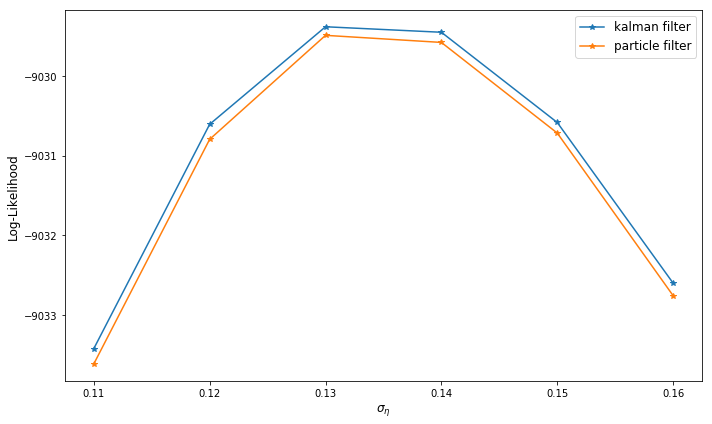

In [161]:
plt.figure(figsize=(10, 6))
plt.plot(etas, log_likelihoods_eta[0], '-*',label='kalman filter')
plt.plot(etas, log_likelihoods_eta[1], '*-',label='particle filter')
plt.xlabel(r'$\sigma_{\eta}$', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/eta_log_likelihood_300_5000.png')
plt.show()

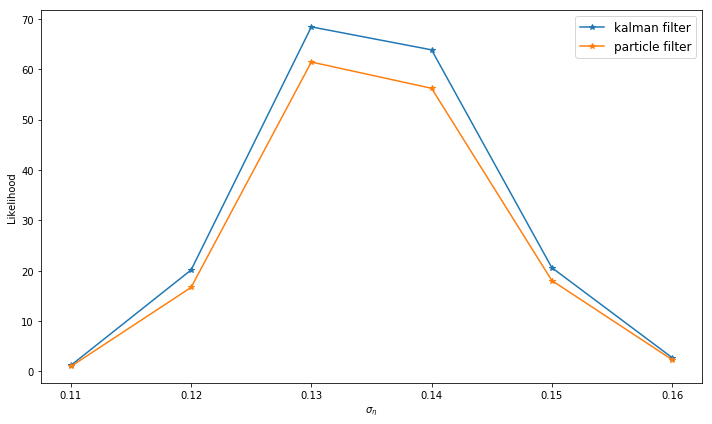

In [162]:
plt.figure(figsize=(10, 6))
plt.plot(etas, np.exp(log_likelihoods_eta[0]-log_likelihoods_eta[1][0]), '-*',label='kalman filter')
plt.plot(etas, np.exp(log_likelihoods_eta[1]-log_likelihoods_eta[1][0]), '*-',label='particle filter')
plt.xlabel(r'$\sigma_{\eta}$')
plt.ylabel('Likelihood')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/eta_likelihood_300_5000.png')
plt.show()

In [125]:
phis = [i*0.001 for i in range(960,1000, 5)]
log_likelihoods_phi = [[], []]
for phi in phis:
    A = phi
    b = (1 - phi) * mu_0
    log_lkh_1, _ = Kalman_Filter.compute_log_likelihood(Y=observations_5000[1:],
                                    mu0=b, 
                                    V0=sigma_eta_square_0, 
                                    A=A, 
                                    b=b, 
                                    V=sigma_eta_square_0,
                                    V_epi=sigma_epsilon_square_0)
    p0 = norm.pdf(observations_5000[0], loc=0, scale=np.sqrt(sigma_epsilon_square_0))
    log_lkh_1 += np.log(p0)
    print("kalman: phi= %0.2f" % phi, " log-lokelihood= %0.3f" % log_lkh_1)
    log_likelihoods_phi[0].append(log_lkh_1)
    
    initial_particles = initial_particle(N=N)
    likelihoods_particle = particle_filter(observations=observations_5000, 
                                  initial_particles=initial_particles,
                                  likelihood_func=likelihood_function, 
                                  transition=transition_sample, 
                                  mu=mu_0,
                                  phi=phi,
                                  sigma_eta_square=sigma_eta_square_0,
                                  sigma_epsilon_square=sigma_epsilon_square_0,
                                  N=N,seed=1234)
    log_lkh_2 = np.sum(np.log(likelihoods_particle))
    print("particle: sigma_eta= %0.2f" % phi, " log-lokelihood= %0.3f" % log_lkh_2)
    log_likelihoods_phi[1].append(log_lkh_2)

Begin compute likelihoods by kalman_filter
kalman: phi= 0.96  log-lokelihood= -9034.717
particle: sigma_eta= 0.96  log-lokelihood= -9034.848
Begin compute likelihoods by kalman_filter
kalman: phi= 0.96  log-lokelihood= -9031.444
particle: sigma_eta= 0.96  log-lokelihood= -9031.490
Begin compute likelihoods by kalman_filter
kalman: phi= 0.97  log-lokelihood= -9029.647
particle: sigma_eta= 0.97  log-lokelihood= -9029.726
Begin compute likelihoods by kalman_filter
kalman: phi= 0.97  log-lokelihood= -9029.555
particle: sigma_eta= 0.97  log-lokelihood= -9029.688
Begin compute likelihoods by kalman_filter
kalman: phi= 0.98  log-lokelihood= -9031.386
particle: sigma_eta= 0.98  log-lokelihood= -9031.573
Begin compute likelihoods by kalman_filter
kalman: phi= 0.98  log-lokelihood= -9035.337
particle: sigma_eta= 0.98  log-lokelihood= -9035.586
Begin compute likelihoods by kalman_filter
kalman: phi= 0.99  log-lokelihood= -9041.573
particle: sigma_eta= 0.99  log-lokelihood= -9041.898
Begin compute

KeyboardInterrupt: 

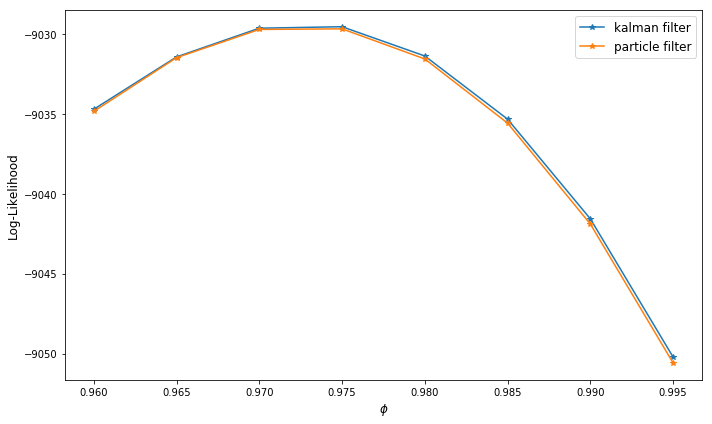

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(phis, log_likelihoods_phi[0], '-*',label='kalman filter')
plt.plot(phis, log_likelihoods_phi[1], '*-',label='particle filter')
plt.xlabel(r'$\phi$', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/phi_log_likelihood_300_5000.png')
plt.show()

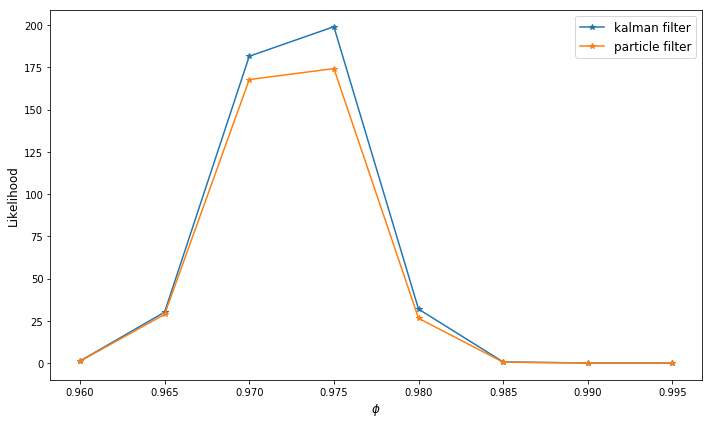

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(phis, np.exp(log_likelihoods_phi[0]-log_likelihoods_phi[1][0]), '-*',label='kalman filter')
plt.plot(phis, np.exp(log_likelihoods_phi[1]-log_likelihoods_phi[1][0]), '*-',label='particle filter')
plt.xlabel(r'$\phi$', fontsize=12)
plt.ylabel('Likelihood', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('image/phi_likelihood_300_5000.png')
plt.show()